In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, accuracy_score
from collections import OrderedDict

pd.set_option('display.max_columns', None)
path = '/Users/aaronng/Downloads/Thesis/'

seed=123
dataset_suffix = ''
type_suffix = ''

np.random.seed(seed)
random.seed(seed)

In [2]:
# Load train and test sets
train_raw = pd.read_csv(path + 'train{}.csv'.format(dataset_suffix))
test_raw = pd.read_csv(path + 'test{}.csv'.format(dataset_suffix))

train_raw['mode'] = np.where(train_raw['mode'] == 'major', 1, 0)
test_raw['mode'] = np.where(test_raw['mode'] == 'major', 1, 0)

train_raw.shape, test_raw.shape

((1617643, 51), (400599, 51))

In [3]:
audio_cols = ['acousticness','beat_strength','bounciness','danceability','dyn_range_mean','energy','flatness','instrumentalness','key','liveness','loudness','mechanism','mode','organism','speechiness','tempo','time_signature','valence']
audio_cols.sort()

# Importing train in this notebook just to perform scaling
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit_transform(train_raw[audio_cols])

test_full = scaler.transform(test_raw[audio_cols])
test_full = pd.DataFrame(test_full, columns=audio_cols)
test_full = pd.concat([test_raw.drop(audio_cols, axis=1), test_full], axis=1)

### Load data

In [4]:
import itertools
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
# Load audio attribute predictions
preds_top3 = pd.read_csv(path + 'top3-features-test{}.csv'.format(type_suffix)).sort_values('session_id').reset_index(drop=True)
preds_top3 = preds_top3.set_index('session_id')
test_no_shuf_ids = preds_top3.index
preds_top3

,top1,top2,top3
session_id,,,
13_00130049-eb6d-476a-aaf4-c0160caffa66,flatness,tempo,mode
13_001d00e8-dd56-4ff0-9144-6230d7f4c6c7,key,mode,liveness
13_0023f682-f2bc-4950-8925-35413d203590,flatness,instrumentalness,energy
13_0038dba3-7d12-4df2-afc7-be15e27edad3,beat_strength,mechanism,mode
13_003c0b49-fc65-4a9c-bcbf-c5205c4aebcf,beat_strength,tempo,mode
...,...,...,...
58_ffdd827f-1e2e-4351-8c3e-f2e444232abc,energy,mode,acousticness
58_ffe22e73-179a-49a9-8ea8-c7568021fe91,acousticness,speechiness,key
58_fff1b8f2-9398-4bbd-8f7d-13e838fe9570,dyn_range_mean,liveness,speechiness


In [6]:
# Load audio attribute ground truths
true_preds = pd.read_csv(path + 'topN-features-test{}{}.csv'.format(dataset_suffix,type_suffix)).sort_values('session_id').reset_index(drop=True)
true_preds = true_preds[true_preds['session_id'].isin(test_no_shuf_ids)]
true_preds = true_preds[(true_preds['top1'] != 'NONE')]

true_preds = true_preds.set_index('session_id')
sess_ids_filt = true_preds.index
true_preds

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14,top15,top16,top17,top18
session_id,,,,,,,,,,,,,,,,,,
36_00042572-ee58-48eb-a6fc-675bda0bbb98,beat_strength,acousticness,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_0007583d-ca87-4edc-8282-987bd32c95be,valence,acousticness,mechanism,energy,loudness,organism,tempo,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_0009b5af-9798-4567-a7e7-03a8c701655f,acousticness,mode,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,speechiness,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_000c1684-8086-4151-b660-be5100368dc2,mode,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36_ffcd0f76-e154-45fe-b561-c38f86729852,valence,acousticness,beat_strength,bounciness,mode,organism,mechanism,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_ffce11b5-0719-4d49-90e4-741fd046e0da,organism,speechiness,energy,beat_strength,bounciness,dyn_range_mean,mechanism,instrumentalness,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE
36_ffce79ff-f6de-4d22-a369-d2280798f17c,bounciness,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE,NONE


In [7]:
true_preds_top1 = true_preds[['top1']]
true_preds_top2 = true_preds[['top1','top2']]
true_preds_top3 = true_preds[['top1','top2','top3']]

In [8]:
preds_top1 = preds_top3[['top1']]
preds_top2 = preds_top3[['top1','top2']]

In [9]:
# Filter test set to only relevant sessions
test = test_full[test_full['session_id'].isin(sess_ids_filt)][['session_id','session_position','skip_2']+audio_cols].reset_index(drop=True)
test['skip_2'] = test['skip_2'].astype(int)
test['relevance'] = test['skip_2'] ^ 1
test = test.set_index('session_id').drop('skip_2',axis=1)
test

,session_position,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,relevance
session_id,,,,,,,,,,,,,,,,,,,,
36_00042572-ee58-48eb-a6fc-675bda0bbb98,1,0.946204,0.235728,0.356757,0.337399,0.232456,0.230894,0.937744,3.562460e-07,0.090909,0.187859,0.832065,0.284091,1.0,0.864734,0.051175,0.692732,1.0,0.428736,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,2,0.079668,0.618124,0.644286,0.797963,0.300100,0.758892,0.893822,1.332862e-09,0.545455,0.080520,0.830038,0.925806,1.0,0.079374,0.054439,0.451819,0.8,0.855310,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,3,0.012234,0.843084,0.890321,0.880344,0.443435,0.547475,0.925688,1.506017e-05,0.636364,0.028050,0.839986,0.805471,1.0,0.142431,0.185094,0.406699,0.8,0.687459,0
36_00042572-ee58-48eb-a6fc-675bda0bbb98,4,0.376191,0.837427,0.852521,0.834778,0.389007,0.484764,0.916195,1.466622e-05,0.909091,0.118421,0.824948,0.758123,0.0,0.325850,0.154805,0.328623,0.8,0.622393,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,5,0.023394,0.420738,0.462627,0.605105,0.247103,0.658409,0.925441,6.004185e-05,0.090909,0.237237,0.836443,0.580488,1.0,0.307031,0.057466,0.595593,0.8,0.267841,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36_ffea5687-1726-4cc8-9131-20a4360be28d,16,0.009507,0.561808,0.605000,0.489579,0.292155,0.789496,0.944146,4.050296e-06,0.727273,0.189042,0.871159,0.529412,1.0,0.343952,0.045305,0.616027,0.8,0.056351,0
36_ffea5687-1726-4cc8-9131-20a4360be28d,17,0.152120,0.483639,0.538218,0.736857,0.273542,0.765143,0.905166,3.328770e-08,0.636364,0.231175,0.842198,0.646154,1.0,0.281271,0.063992,0.451687,0.8,0.518047,1
36_ffea5687-1726-4cc8-9131-20a4360be28d,18,0.216619,0.473308,0.511737,0.450246,0.260786,0.612497,0.900555,1.364814e-11,0.181818,0.080037,0.833782,0.335878,1.0,0.510265,0.072920,0.401520,0.8,0.213145,1


In [10]:
# Load extracted states
states_full = pd.read_csv(path + 'states-test{}{}.csv'.format(dataset_suffix,type_suffix))
states = states_full[states_full['session_id'].isin(sess_ids_filt)]
states = states.set_index('session_id')
states

,session_position,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,relevance
session_id,,,,,,,,,,,,,,,,,,,,
36_00042572-ee58-48eb-a6fc-675bda0bbb98,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
36_00042572-ee58-48eb-a6fc-675bda0bbb98,4,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36_ffea5687-1726-4cc8-9131-20a4360be28d,16,0,2,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0
36_ffea5687-1726-4cc8-9131-20a4360be28d,17,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1
36_ffea5687-1726-4cc8-9131-20a4360be28d,18,2,0,0,0,0,0,0,0,2,0,0,1,1,0,1,0,0,0,1


### Current Metrics

In [13]:
K=10
N=5

In [14]:
# Add popularity score to test set
pop = test_full[test_full['session_id'].isin(sess_ids_filt)]['us_popularity_estimate']
test_pop = copy.deepcopy(test)
pop_scaler = MinMaxScaler(feature_range=(0,1))
size = len(test_full)-1
test_pop['us_popularity_estimate'] = pop.rank().apply(lambda x: (x-1)/size).values

In [15]:
from sklearn.metrics import f1_score

# Metric definitions
# https://gist.github.com/bwhite/3726239/
def dcg_score(y_score, k=999):
    y = y_score[:k]
    score = 0
    
    for i in range(len(y)):
        score += (2**y[i] - 1) / np.log2(i+2)

    return np.sum(score)

def ndcg_score(y_score, k=999):
    y = y_score[:k]
    
    idcg = dcg_score(sorted(y_score, reverse=True), k)
    return dcg_score(y_score, k) / idcg if idcg > 0 else 0

def precision_score(y_score, k=999):
    cumulative_score = 0
    num_pos = 0
    y = y_score[:k]
    
    return np.sum(y) / len(y)

def average_precision_score(y_score, k=999):
    cumulative_score = 0
    num_pos = 0
    y = y_score[:k]
    
    for i in range(len(y)):
        if y[i] == 1:
            num_pos += 1
            cumulative_score += num_pos / (i+1)
    
    return cumulative_score / num_pos if num_pos > 0 else 0

def reciprocal_rank(y_score, k=999):
    y = y_score[:k]
    
    try:
        return 1/(y.index(1)+1)
    except ValueError:
        return 0

In [16]:
def calc_current_metrics(data, K=10, N=5):
    metrics = []
    count=0

    for session_id in data.index.unique():
        session_data = data.loc[session_id]
        session_data = session_data[session_data['session_position'] > N].reset_index(drop=True)
        y = list(session_data['relevance'])
        popularity = list(session_data['us_popularity_estimate'])
        
        popularity_K = np.mean(popularity[:K])
        popularity_5 = np.mean(popularity[:5])
        popularity_3 = np.mean(popularity[:3])
        ndcg_K = ndcg_score(y, K)
        ndcg_5 = ndcg_score(y, 5)
        ndcg_3 = ndcg_score(y, 3)
        ap_K = average_precision_score(y, K)
        ap_5 = average_precision_score(y, 5)
        ap_3 = average_precision_score(y, 3)
        p_K = precision_score(y, K)
        p_5 = precision_score(y, 5)
        p_3 = precision_score(y, 3)
        rr_K = reciprocal_rank(y, K)
        rr_5 = reciprocal_rank(y, 5)
        rr_3 = reciprocal_rank(y, 3)
        
        metrics.append([session_id, ndcg_K, ndcg_5, ndcg_3, popularity_K, popularity_5, popularity_3, ap_K, ap_5, ap_3, p_K, p_5, p_3, rr_K, rr_5, rr_3])

        count+=1
        if count%100 == 0:
            print('Processed {} sessions'.format(count))
            
    return pd.DataFrame(metrics, columns=[
        'session_id',
        'NDCG@{}'.format(K), 
        'NDCG@{}'.format(5), 
        'NDCG@{}'.format(3),
        'Popularity@{}'.format(K), 
        'Popularity@{}'.format(5), 
        'Popularity@{}'.format(3),
        'AP@{}'.format(K),
        'AP@{}'.format(5),
        'AP@{}'.format(3),
        'P@{}'.format(K),
        'P@{}'.format(5),
        'P@{}'.format(3),
        'RR@{}'.format(K),
        'RR@{}'.format(5),
        'RR@{}'.format(3),
    ])

In [ ]:
current_metrics = calc_current_metrics(test_pop[['session_position','relevance','us_popularity_estimate']], N=N)
current_metrics

In [18]:
current_metrics.mean()

NDCG@10          0.667033
NDCG@5           0.555151
NDCG@3           0.505866
Popularity@10    0.263430
Popularity@5     0.263938
Popularity@3     0.264499
AP@10            0.614331
AP@5             0.606686
AP@3             0.581324
P@10             0.529408
P@5              0.502602
P@3              0.490169
RR@10            0.627458
RR@5             0.609620
RR@3             0.581546
dtype: float64

### Prediction Metrics

In [118]:
scaler = MinMaxScaler()

def calc_pred_metrics(states, feats, data, K=10, N=5, max_states=3, mechanism=''):
    metrics = []
    count=0

    for session_id in states.index.unique():
        session_states = states.loc[session_id].reset_index(drop=True)
        session_topN_feats = list(feats.loc[session_id].values)
        session_topN_feats = [feat for feat in session_topN_feats if feat != 'NONE']
        session_topN_feats = list(OrderedDict.fromkeys(session_topN_feats)) # Remove duplicate topN features
        print(session_topN_feats)
        
        session_firstN = session_states[session_states['session_position'] <= N][session_topN_feats + ['relevance']]
        rel_tracks = np.sum(list(session_firstN['relevance']))
        
        # Replace non-relevant tracks (0) with -1 score, relevant tracks (1) remain as score of 1
        session_firstN['score'] = session_firstN['relevance'].replace(0,-1)
        session_remaining = session_states[session_states['session_position'] > N][session_topN_feats + ['session_position','relevance']]
        
        session_data = data.loc[session_id].reset_index(drop=True)
        session_remaining.insert(len(session_remaining.columns), 'us_popularity_estimate', session_data[session_data['session_position'] > N]['us_popularity_estimate'].values)
        
        for feat in session_topN_feats:
            if mechanism == 'best_states':
                feat_scores_dict = session_remaining[[feat, 'relevance']].groupby(feat).sum().sort_values('relevance', ascending=False).to_dict()['relevance']
            else:
                feat_scores_dict = session_firstN[[feat, 'score']].groupby(feat).sum().sort_values('score', ascending=False).to_dict()['score']
            
            # Replace best state with score of 1, rest 0
            best_state = list(feat_scores_dict.keys())[0]
            feat_scores_dict = {best_state: 1}
            
            # Fill rest of dict (unseen states) with score of 0
            for i in range(max_states):
                if i not in feat_scores_dict:
                    feat_scores_dict[i]=0
                    
            session_remaining[feat+'_score'] = session_remaining[feat].replace(feat_scores_dict)
        
        feat_score_cols = [col for col in session_remaining.columns if '_score' in col]
        session_remaining.insert(len(session_remaining.columns), 'score', session_remaining[feat_score_cols].sum(axis=1))

        #######
        # Model Variants
        #######
        if 'cos_sim' in mechanism:
            session_remaining_data = session_data[session_data['session_position'] > N][audio_cols].values

            session_firstN_data_mean = session_data[session_data['session_position'] <= N][audio_cols].mean()
            session_firstN_data_mean = np.repeat([session_firstN_data_mean.values], len(session_remaining), axis=0)

            session_remaining.insert(len(session_remaining.columns), 'cos_sim', np.diagonal(cosine_similarity(session_firstN_data_mean, session_remaining_data)))
            
            session_remaining['cos_sim'] = scaler.fit_transform(session_remaining['cos_sim'].values.reshape(-1, 1))
            session_remaining['score'] = scaler.fit_transform(session_remaining['score'].values.reshape(-1, 1))
            
            if mechanism == 'weighted_cos_sim':
                session_remaining['total_score'] = 0.5*session_remaining['cos_sim'] + 0.5*session_remaining['score']
                session_remaining = session_remaining.sort_values(['total_score'], ascending=[False])
            elif mechanism == 'weighted_cos_sim_user_track':
                session_remaining['user_track'] = scaler.fit_transform(np.array([1/(val-N) for val in session_remaining['session_position'].values]).reshape(-1, 1))
                session_remaining['total_score'] = 0.333*session_remaining['cos_sim'] + 0.333*session_remaining['score'] + 0.333*session_remaining['user_track']
                session_remaining = session_remaining.sort_values(['total_score'], ascending=[False])
            elif mechanism == 'weighted_pop_cos_sim_plus':
                session_remaining['popularity'] = scaler.fit_transform(session_remaining['us_popularity_estimate'].values.reshape(-1, 1))
                session_remaining['total_score'] = 0.333*session_remaining['cos_sim'] + 0.333*session_remaining['popularity'] + 0.333*session_remaining['score']
                session_remaining = session_remaining.sort_values(['total_score'], ascending=[False])
            else:
                session_remaining = session_remaining.sort_values(['score','cos_sim'], ascending=[False,False])
        elif 'pop' in mechanism:
            session_remaining['popularity'] = scaler.fit_transform(session_remaining['us_popularity_estimate'].values.reshape(-1, 1))
            session_remaining['score'] = scaler.fit_transform(session_remaining['score'].values.reshape(-1, 1))
            
            if mechanism == 'weighted_pop':
                session_remaining['total_score'] = 0.5*session_remaining['popularity'] + 0.5*session_remaining['score']
                session_remaining = session_remaining.sort_values(['total_score'], ascending=[False])
            else:
                session_remaining = session_remaining.sort_values(['score','popularity'], ascending=[False,False])
        else:
            session_remaining = session_remaining.sort_values(['score','session_position'], ascending=[False,True])

        pred = list(session_remaining['relevance'])
        popularity = list(session_remaining['us_popularity_estimate'])
        
        popularity_K = np.mean(popularity[:K])
        popularity_5 = np.mean(popularity[:5])
        popularity_3 = np.mean(popularity[:3])
        ndcg_K = ndcg_score(pred, K)
        ndcg_5 = ndcg_score(pred, 5)
        ndcg_3 = ndcg_score(pred, 3)
        ap_K = average_precision_score(pred, K)
        ap_5 = average_precision_score(pred, 5)
        ap_3 = average_precision_score(pred, 3)
        p_K = precision_score(pred, K)
        p_5 = precision_score(pred, 5)
        p_3 = precision_score(pred, 3)
        rr_K = reciprocal_rank(pred, K)
        rr_5 = reciprocal_rank(pred, 5)
        rr_3 = reciprocal_rank(pred, 3)
        
        metrics.append([session_id, ndcg_K, ndcg_5, ndcg_3, popularity_K, popularity_5, popularity_3, \
                        ap_K, ap_5, ap_3, p_K, p_5, p_3, rr_K, rr_5, rr_3, \
                        rel_tracks, np.sum(pred), len(pred)
                       ])

        count+=1
        if count%10 == 0:
            print('Processed {} sessions'.format(count))
    
    topN = feats.values.shape[1]
    return pd.DataFrame(metrics, columns=[
        'session_id',
        'NDCG@{}_top{}'.format(K, topN), 
        'NDCG@{}_top{}'.format(5, topN), 
        'NDCG@{}_top{}'.format(3, topN),
        'Popularity@{}_top{}'.format(K, topN), 
        'Popularity@{}_top{}'.format(5, topN), 
        'Popularity@{}_top{}'.format(3, topN),
        'AP@{}_top{}'.format(K, topN),
        'AP@{}_top{}'.format(5, topN),
        'AP@{}_top{}'.format(3, topN),
        'P@{}_top{}'.format(K, topN),
        'P@{}_top{}'.format(5, topN),
        'P@{}_top{}'.format(3, topN),
        'RR@{}_top{}'.format(K, topN),
        'RR@{}_top{}'.format(5, topN),
        'RR@{}_top{}'.format(3, topN),
        'Relevant firstN','Relevant remaining','Length remaining'
    ])

### Prediction Base Metrics

In [ ]:
pred_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N)
pred_metrics1

In [21]:
pred_metrics1.mean()

NDCG@10_top1           0.687243
NDCG@5_top1            0.586662
NDCG@3_top1            0.534217
Popularity@10_top1     0.263580
Popularity@5_top1      0.264272
Popularity@3_top1      0.264344
AP@10_top1             0.630020
AP@5_top1              0.633708
AP@3_top1              0.612705
P@10_top1              0.535985
P@5_top1               0.529081
P@3_top1               0.519217
RR@10_top1             0.655433
RR@5_top1              0.641967
RR@3_top1              0.614180
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N)
pred_metrics2

In [23]:
pred_metrics2.mean()

NDCG@10_top2           0.689909
NDCG@5_top2            0.591386
NDCG@3_top2            0.542101
Popularity@10_top2     0.263721
Popularity@5_top2      0.264267
Popularity@3_top2      0.264841
AP@10_top2             0.632121
AP@5_top2              0.639771
AP@3_top2              0.624730
P@10_top2              0.536367
P@5_top2               0.531110
P@3_top2               0.526084
RR@10_top2             0.665304
RR@5_top2              0.653463
RR@3_top2              0.627572
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N)
pred_metrics3

In [25]:
pred_metrics3.mean()

NDCG@10_top3           0.693426
NDCG@5_top3            0.595428
NDCG@3_top3            0.547906
Popularity@10_top3     0.263697
Popularity@5_top3      0.264692
Popularity@3_top3      0.264652
AP@10_top3             0.635498
AP@5_top3              0.645239
AP@3_top3              0.633499
P@10_top3              0.536870
P@5_top3               0.533140
P@3_top3               0.530205
RR@10_top3             0.673590
RR@5_top3              0.661854
RR@3_top3              0.637200
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [26]:
pred_metrics = copy.deepcopy(pred_metrics1)
pred_metrics = pred_metrics.merge(pred_metrics2, on='session_id')
pred_metrics = pred_metrics.merge(pred_metrics3, on='session_id')
pred_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.00,1.0,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750,1.0,0.400000,0.4,0.333333,1.000,1.00,1.0,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750,1.0,0.400000,0.4,0.333333,1.00,1.00,1.0,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.129430,0.178619,0.196028,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00,1.0,1,15,15,1.000000,1.000000,1.000000,0.119547,0.133306,0.158493,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.000,1.00,1.0,1,15,15,1.000000,1.000000,1.000000,0.129430,0.121383,0.101675,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00,1.0,4,6,6,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.000,1.00,1.0,4,6,6,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000,1.0,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.250000,0.25,0.0,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325,0.0,0.428571,0.4,0.000000,0.250,0.25,0.0,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325,0.0,0.428571,0.4,0.000000,0.25,0.25,0.0,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.361815,0.000000,0.000000,0.240759,0.255250,0.260312,0.155556,0.000000,0.000000,0.200000,0.0,0.000000,0.111111,0.00,0.0,3,2,15,0.378002,0.000000,0.000000,0.272186,0.255250,0.260312,0.173611,0.000,0.0,0.200000,0.0,0.000000,0.125,0.00,0.0,3,2,15,0.264068,0.264068,0.000000,0.247954,0.264109,0.219615,0.250000,0.250,0.0,0.100000,0.2,0.000000,0.25,0.25,0.0,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,0.921602,1.000000,1.000000,0.422755,0.418010,0.407963,0.946781,1.000000,1.000000,0.900000,1.0,1.000000,1.000000,1.00,1.0,3,14,15,0.930569,1.000000,1.000000,0.420238,0.418010,0.407963,0.976543,1.000,1.0,0.900000,1.0,1.000000,1.000,1.00,1.0,3,14,15,0.921602,1.000000,1.000000,0.422755,0.418010,0.407963,0.946781,1.000,1.0,0.900000,1.0,1.000000,1.00,1.00,1.0,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.689135,0.441492,0.530721,0.199192,0.221845,0.219356,0.509921,0.583333,0.583333,0.444444,0.4,0.666667,0.500000,0.50,0.5,3,4,9,0.543354,0.151020,0.000000,0.199192,0.210574,0.181702,0.365476,0.200,0.0,0.444444,0.2,0.000000,0.200,0.20,0.0,3,4,9,0.617096,0.246302,0.296082,0.199192,0.210574,0.225102,0.401290,0.500,0.5,0.444444,0.2,0.333333,0.50,0.50,0.5,3,4,9
13102,36_ffce79ff-f6de-4d22-a369-d2280798f17c,0.434033,0.213986,0.296082,0.298361,0.281930,0.225111,0.386905,0.500000,0.500000,0.300000,0.2,0.333333,0.500000,0.50,0.5,4,5,15,0.545890,0.213986,0.296082,0.279940,0.266581,0.225111

### Prediction (tie-break cos-sim) metrics

In [ ]:
pred_cossim_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N, mechanism='cos_sim')
pred_cossim_metrics1

In [28]:
pred_cossim_metrics1.mean()

NDCG@10_top1           0.708232
NDCG@5_top1            0.615058
NDCG@3_top1            0.570866
Popularity@10_top1     0.263894
Popularity@5_top1      0.265167
Popularity@3_top1      0.266627
AP@10_top1             0.649879
AP@5_top1              0.664306
AP@3_top1              0.660899
P@10_top1              0.539946
P@5_top1               0.543380
P@3_top1               0.548340
RR@10_top1             0.699884
RR@5_top1              0.689981
RR@3_top1              0.668485
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_cossim_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N, mechanism='cos_sim')
pred_cossim_metrics2

In [30]:
pred_cossim_metrics2.mean()

NDCG@10_top2           0.706380
NDCG@5_top2            0.613216
NDCG@3_top2            0.569120
Popularity@10_top2     0.263946
Popularity@5_top2      0.264962
Popularity@3_top2      0.266151
AP@10_top2             0.647627
AP@5_top2              0.662751
AP@3_top2              0.658038
P@10_top2              0.539671
P@5_top2               0.543274
P@3_top2               0.548086
RR@10_top2             0.696951
RR@5_top2              0.686877
RR@3_top2              0.665560
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_cossim_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N, mechanism='cos_sim')
pred_cossim_metrics3

In [32]:
pred_cossim_metrics3.mean()

NDCG@10_top3           0.706693
NDCG@5_top3            0.614352
NDCG@3_top3            0.572727
Popularity@10_top3     0.263971
Popularity@5_top3      0.265176
Popularity@3_top3      0.265682
AP@10_top3             0.650120
AP@5_top3              0.665172
AP@3_top3              0.661910
P@10_top3              0.538809
P@5_top3               0.543121
P@3_top3               0.551037
RR@10_top3             0.700366
RR@5_top3              0.690279
RR@3_top3              0.669783
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [33]:
pred_cossim_metrics = copy.deepcopy(pred_cossim_metrics1)
pred_cossim_metrics = pred_cossim_metrics.merge(pred_cossim_metrics2, on='session_id')
pred_cossim_metrics = pred_cossim_metrics.merge(pred_cossim_metrics3, on='session_id')
pred_cossim_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.000000,1.000000,1.000000,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.000000,1.000000,1.000000,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.134517,0.128795,0.094156,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.119547,0.114583,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.099071,0.121383,0.101675,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.386853,0.386853,0.386853,0.237482,0.304770,0.310505,0.500000,0.500000,0.500000,0.100000,0.2,0.333333,0.500000,0.500000,0.500000,3,2,15,0.564092,0.386853,0.386853,0.272186,0.304770,0.310505,0.350000,0.500000,0.500000,0.200000,0.2,0.333333,0.500000,0.500000,0.500000,3,2,15,0.613147,0.613147,0.613147,0.247954,0.267224,0.296699,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.410300,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.782714,0.390380,0.469279,0.199192,0.210574,0.263795,0.565476,1.000000,1.000000,0.444444,0.2,0.333333,1.000000,1.000000,1.000000,3,4,9,0.572425,0.319147,0.000000,0.199192,0.145967,0.181702,0.394643,0.325000,0.000000,0.444444,0.4,0.000000,0.250000,0.250000,0.000000,3,4,9,0.770104,0.39

### Prediction (weighted cos-sim) metrics

In [ ]:
pred_weight_cossim_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N, mechanism='weighted_cos_sim')
pred_weight_cossim_metrics1

In [35]:
pred_weight_cossim_metrics1.mean()

NDCG@10_top1           0.707509
NDCG@5_top1            0.613799
NDCG@3_top1            0.569674
Popularity@10_top1     0.263908
Popularity@5_top1      0.265277
Popularity@3_top1      0.266732
AP@10_top1             0.648853
AP@5_top1              0.663157
AP@3_top1              0.659818
P@10_top1              0.539938
P@5_top1               0.542846
P@3_top1               0.547603
RR@10_top1             0.698898
RR@5_top1              0.688872
RR@3_top1              0.667506
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weight_cossim_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N, mechanism='weighted_cos_sim')
pred_weight_cossim_metrics2

In [37]:
pred_weight_cossim_metrics2.mean()

NDCG@10_top2           0.705821
NDCG@5_top2            0.612429
NDCG@3_top2            0.569638
Popularity@10_top2     0.264061
Popularity@5_top2      0.265658
Popularity@3_top2      0.266829
AP@10_top2             0.647319
AP@5_top2              0.662311
AP@3_top2              0.658120
P@10_top2              0.539511
P@5_top2               0.542953
P@3_top2               0.549358
RR@10_top2             0.696684
RR@5_top2              0.686466
RR@3_top2              0.665916
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weight_cossim_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N, mechanism='weighted_cos_sim')
pred_weight_cossim_metrics3

In [39]:
pred_weight_cossim_metrics3.mean()

NDCG@10_top3           0.707493
NDCG@5_top3            0.614414
NDCG@3_top3            0.571491
Popularity@10_top3     0.264195
Popularity@5_top3      0.265853
Popularity@3_top3      0.266778
AP@10_top3             0.650015
AP@5_top3              0.665134
AP@3_top3              0.661713
P@10_top3              0.539488
P@5_top3               0.543167
P@3_top3               0.549256
RR@10_top3             0.700421
RR@5_top3              0.690240
RR@3_top3              0.669515
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [40]:
pred_weight_cossim_metrics = copy.deepcopy(pred_weight_cossim_metrics1)
pred_weight_cossim_metrics = pred_weight_cossim_metrics.merge(pred_weight_cossim_metrics2, on='session_id')
pred_weight_cossim_metrics = pred_weight_cossim_metrics.merge(pred_weight_cossim_metrics3, on='session_id')
pred_weight_cossim_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.000000,1.000000,1.000000,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.000000,1.000000,1.000000,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.134517,0.128795,0.094156,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.103654,0.114583,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.097693,0.097217,0.101675,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7,0.525694,0.202107,0.000000,0.038582,0.036938,0.036559,0.337302,0.250000,0.000000,0.428571,0.2,0.000000,0.250000,0.250000,0.000000,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.386853,0.386853,0.386853,0.237482,0.304770,0.310505,0.500000,0.500000,0.500000,0.100000,0.2,0.333333,0.500000,0.500000,0.500000,3,2,15,0.386853,0.386853,0.386853,0.268909,0.304770,0.310505,0.500000,0.500000,0.500000,0.100000,0.2,0.333333,0.500000,0.500000,0.500000,3,2,15,0.613147,0.613147,0.613147,0.282866,0.292322,0.310505,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.410300,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.782714,0.390380,0.469279,0.199192,0.210574,0.263795,0.565476,1.000000,1.000000,0.444444,0.2,0.333333,1.000000,1.000000,1.000000,3,4,9,0.610960,0.363318,0.234639,0.199192,0.177876,0.186082,0.426587,0.416667,0.333333,0.444444,0.4,0.333333,0.333333,0.333333,0.333333,3,4,9,0.782067,0.54

### Prediction (tie-break popularity) metrics

In [ ]:
pred_pop_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N, mechanism='pop')
pred_pop_metrics1

In [49]:
pred_pop_metrics1.mean()

NDCG@10_top1           0.716942
NDCG@5_top1            0.625364
NDCG@3_top1            0.582206
Popularity@10_top1     0.274052
Popularity@5_top1      0.292015
Popularity@3_top1      0.313903
AP@10_top1             0.658782
AP@5_top1              0.675975
AP@3_top1              0.673948
P@10_top1              0.541594
P@5_top1               0.549134
P@3_top1               0.555971
RR@10_top1             0.711658
RR@5_top1              0.702254
RR@3_top1              0.682093
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_pop_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N, mechanism='pop')
pred_pop_metrics2

In [51]:
pred_pop_metrics2.mean()

NDCG@10_top2           0.712937
NDCG@5_top2            0.621244
NDCG@3_top2            0.577434
Popularity@10_top2     0.271635
Popularity@5_top2      0.286413
Popularity@3_top2      0.298307
AP@10_top2             0.654542
AP@5_top2              0.670591
AP@3_top2              0.666794
P@10_top2              0.540983
P@5_top2               0.547272
P@3_top2               0.552919
RR@10_top2             0.705954
RR@5_top2              0.696663
RR@3_top2              0.675137
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_pop_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N, mechanism='pop')
pred_pop_metrics3

In [53]:
pred_pop_metrics3.mean()

NDCG@10_top3           0.712579
NDCG@5_top3            0.620226
NDCG@3_top3            0.578218
Popularity@10_top3     0.270510
Popularity@5_top3      0.283137
Popularity@3_top3      0.293514
AP@10_top3             0.654140
AP@5_top3              0.671245
AP@3_top3              0.668326
P@10_top3              0.540976
P@5_top3               0.546555
P@3_top3               0.554063
RR@10_top3             0.706503
RR@5_top3              0.697010
RR@3_top3              0.676548
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [54]:
pred_pop_metrics = copy.deepcopy(pred_pop_metrics1)
pred_pop_metrics = pred_pop_metrics.merge(pred_pop_metrics2, on='session_id')
pred_pop_metrics = pred_pop_metrics.merge(pred_pop_metrics3, on='session_id')
pred_pop_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.693426,0.693426,0.693426,0.465666,0.465666,0.487389,0.583333,0.583333,0.583333,0.400000,0.4,0.666667,0.500000,0.500000,0.500000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.134517,0.194781,0.232338,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.119547,0.172260,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.130164,0.121383,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.634050,0.477624,0.296082,0.038582,0.038955,0.036961,0.442857,0.450000,0.500000,0.428571,0.4,0.333333,0.500000,0.500000,0.500000,2,3,7,0.634050,0.477624,0.296082,0.038582,0.038955,0.036961,0.442857,0.450000,0.500000,0.428571,0.4,0.333333,0.500000,0.500000,0.500000,2,3,7,0.634050,0.477624,0.296082,0.038582,0.038955,0.036961,0.442857,0.450000,0.500000,0.428571,0.4,0.333333,0.500000,0.500000,0.500000,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.613147,0.613147,0.613147,0.247954,0.304770,0.335291,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.790386,0.613147,0.613147,0.272186,0.304770,0.335291,0.600000,1.000000,1.000000,0.200000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.613147,0.613147,0.613147,0.247954,0.290747,0.296699,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,1.000000,1.000000,1.000000,0.436552,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.436552,0.418010,0.410300,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.593852,0.346210,0.234639,0.199192,0.221845,0.263795,0.401587,0.366667,0.333333,0.444444,0.4,0.333333,0.333333,0.333333,0.333333,3,4,9,0.543354,0.151020,0.000000,0.199192,0.210574,0.181702,0.365476,0.200000,0.000000,0.444444,0.2,0.000000,0.200000,0.200000,0.000000,3,4,9,0.574914,0.19

### Prediction (weighted popularity) metrics

In [ ]:
pred_weighted_pop_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N, mechanism='weighted_pop')
pred_weighted_pop_metrics1

In [56]:
pred_weighted_pop_metrics1.mean()

NDCG@10_top1           0.716340
NDCG@5_top1            0.624542
NDCG@3_top1            0.581084
Popularity@10_top1     0.274316
Popularity@5_top1      0.293049
Popularity@3_top1      0.315319
AP@10_top1             0.657916
AP@5_top1              0.675167
AP@3_top1              0.672917
P@10_top1              0.541525
P@5_top1               0.548722
P@3_top1               0.555233
RR@10_top1             0.710918
RR@5_top1              0.701487
RR@3_top1              0.681216
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weighted_pop_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N, mechanism='weighted_pop')
pred_weighted_pop_metrics2

In [58]:
pred_weighted_pop_metrics2.mean()

NDCG@10_top2           0.716327
NDCG@5_top2            0.624742
NDCG@3_top2            0.581802
Popularity@10_top2     0.277212
Popularity@5_top2      0.301603
Popularity@3_top2      0.320419
AP@10_top2             0.658030
AP@5_top2              0.674127
AP@3_top2              0.670940
P@10_top2              0.542082
P@5_top2               0.549027
P@3_top2               0.556734
RR@10_top2             0.709219
RR@5_top2              0.699916
RR@3_top2              0.679092
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weighted_pop_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N, mechanism='weighted_pop')
pred_weighted_pop_metrics3

In [60]:
pred_weighted_pop_metrics3.mean()

NDCG@10_top3           0.716852
NDCG@5_top3            0.626160
NDCG@3_top3            0.583782
Popularity@10_top3     0.277974
Popularity@5_top3      0.303174
Popularity@3_top3      0.322207
AP@10_top3             0.659187
AP@5_top3              0.676742
AP@3_top3              0.673477
P@10_top3              0.541731
P@5_top3               0.549714
P@3_top3               0.558489
RR@10_top3             0.711417
RR@5_top3              0.702802
RR@3_top3              0.681928
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [61]:
pred_weighted_pop_metrics = copy.deepcopy(pred_weighted_pop_metrics1)
pred_weighted_pop_metrics = pred_weighted_pop_metrics.merge(pred_weighted_pop_metrics2, on='session_id')
pred_weighted_pop_metrics = pred_weighted_pop_metrics.merge(pred_weighted_pop_metrics3, on='session_id')
pred_weighted_pop_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.693426,0.693426,0.693426,0.465666,0.465666,0.487389,0.583333,0.583333,0.583333,0.400000,0.4,0.666667,0.500000,0.500000,0.500000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.134517,0.194781,0.232338,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.119547,0.194781,0.232338,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.130164,0.172260,0.232338,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.125988,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.687148,0.530721,0.530721,0.038582,0.038955,0.040821,0.531746,0.583333,0.583333,0.428571,0.4,0.666667,0.500000,0.500000,0.500000,2,3,7,0.687148,0.530721,0.530721,0.038582,0.038955,0.040821,0.531746,0.583333,0.583333,0.428571,0.4,0.666667,0.500000,0.500000,0.500000,2,3,7,0.687148,0.530721,0.530721,0.038582,0.038955,0.040821,0.531746,0.583333,0.583333,0.428571,0.4,0.666667,0.500000,0.500000,0.500000,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.613147,0.613147,0.613147,0.247954,0.304770,0.335291,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.797723,0.613147,0.613147,0.272186,0.304770,0.335291,0.611111,1.000000,1.000000,0.200000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.797723,0.613147,0.613147,0.295665,0.323123,0.349709,0.611111,1.000000,1.000000,0.200000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,1.000000,1.000000,1.000000,0.436552,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.436552,0.435560,0.433323,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.593852,0.346210,0.234639,0.199192,0.221845,0.263795,0.401587,0.366667,0.333333,0.444444,0.4,0.333333,0.333333,0.333333,0.333333,3,4,9,0.543354,0.151020,0.000000,0.199192,0.274169,0.181702,0.365476,0.200000,0.000000,0.444444,0.2,0.000000,0.200000,0.200000,0.000000,3,4,9,0.581889,0.19

### Prediction (weighted popularity + others) metrics

In [ ]:
pred_weighted_pop_plus_metrics1 = calc_pred_metrics(states, preds_top1, test_pop, N=N, mechanism='weighted_pop_cos_sim_plus')
pred_weighted_pop_plus_metrics1

In [63]:
pred_weighted_pop_plus_metrics1.mean()

NDCG@10_top1           0.716950
NDCG@5_top1            0.626011
NDCG@3_top1            0.581628
Popularity@10_top1     0.274459
Popularity@5_top1      0.293648
Popularity@3_top1      0.310922
AP@10_top1             0.658738
AP@5_top1              0.675857
AP@3_top1              0.673611
P@10_top1              0.541647
P@5_top1               0.549744
P@3_top1               0.555208
RR@10_top1             0.712088
RR@5_top1              0.702774
RR@3_top1              0.682068
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weighted_pop_plus_metrics2 = calc_pred_metrics(states, preds_top2, test_pop, N=N, mechanism='weighted_pop_cos_sim_plus')
pred_weighted_pop_plus_metrics2

In [65]:
pred_weighted_pop_plus_metrics2.mean()

NDCG@10_top2           0.717560
NDCG@5_top2            0.628016
NDCG@3_top2            0.584469
Popularity@10_top2     0.275723
Popularity@5_top2      0.297744
Popularity@3_top2      0.314563
AP@10_top2             0.660410
AP@5_top2              0.677782
AP@3_top2              0.676631
P@10_top2              0.541388
P@5_top2               0.551194
P@3_top2               0.558057
RR@10_top2             0.714638
RR@5_top2              0.705694
RR@3_top2              0.685247
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
pred_weighted_pop_plus_metrics3 = calc_pred_metrics(states, preds_top3, test_pop, N=N, mechanism='weighted_pop_cos_sim_plus')
pred_weighted_pop_plus_metrics3

In [67]:
pred_weighted_pop_plus_metrics3.mean()

NDCG@10_top3           0.717390
NDCG@5_top3            0.627541
NDCG@3_top3            0.585500
Popularity@10_top3     0.276027
Popularity@5_top3      0.298592
Popularity@3_top3      0.315418
AP@10_top3             0.661005
AP@5_top3              0.678793
AP@3_top3              0.677146
P@10_top3              0.540991
P@5_top3               0.550568
P@3_top3               0.559430
RR@10_top3             0.714127
RR@5_top3              0.705177
RR@3_top3              0.684624
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [68]:
pred_weighted_pop_plus_metrics = copy.deepcopy(pred_weighted_pop_plus_metrics1)
pred_weighted_pop_plus_metrics = pred_weighted_pop_plus_metrics.merge(pred_weighted_pop_plus_metrics2, on='session_id')
pred_weighted_pop_plus_metrics = pred_weighted_pop_plus_metrics.merge(pred_weighted_pop_plus_metrics3, on='session_id')
pred_weighted_pop_plus_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.693426,0.693426,0.693426,0.465666,0.465666,0.487389,0.583333,0.583333,0.583333,0.400000,0.4,0.666667,0.500000,0.500000,0.500000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.000000,1.000000,1.000000,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.134517,0.172260,0.232338,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.133372,0.134349,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.134748,0.134349,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.125988,0.143756,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.250000,0.250000,0.000000,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.250000,0.250000,0.000000,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.250000,0.250000,0.000000,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.613147,0.613147,0.613147,0.311326,0.304770,0.335291,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.613147,0.613147,0.613147,0.311326,0.304770,0.335291,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15,0.613147,0.613147,0.613147,0.311326,0.331407,0.349709,1.000000,1.000000,1.000000,0.100000,0.2,0.333333,1.000000,1.000000,1.000000,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,1.000000,1.000000,1.000000,0.436552,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.431270,0.418010,0.437342,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15,1.000000,1.000000,1.000000,0.436552,0.418010,0.433323,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.616595,0.363318,0.234639,0.199192,0.276797,0.263795,0.440476,0.416667,0.333333,0.444444,0.4,0.333333,0.333333,0.333333,0.333333,3,4,9,0.602782,0.346210,0.234639,0.199192,0.276797,0.369786,0.419444,0.366667,0.333333,0.444444,0.4,0.333333,0.333333,0.333333,0.333333,3,4,9,0.619890,0.36

### Top3 predicted correctly metrics

In [ ]:
true_pred_metrics1 = calc_pred_metrics(states, true_preds_top1, test_pop, N=N)
true_pred_metrics1

In [70]:
true_pred_metrics1.mean()

NDCG@10_top1           0.729428
NDCG@5_top1            0.653982
NDCG@3_top1            0.596525
Popularity@10_top1     0.263800
Popularity@5_top1      0.264807
Popularity@3_top1      0.264812
AP@10_top1             0.680873
AP@5_top1              0.686824
AP@3_top1              0.670368
P@10_top1              0.544043
P@5_top1               0.576375
P@3_top1               0.571894
RR@10_top1             0.705441
RR@5_top1              0.696625
RR@3_top1              0.672008
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
true_pred_metrics2 = calc_pred_metrics(states, true_preds_top2, test_pop, N=N)
true_pred_metrics2

In [72]:
true_pred_metrics2.mean()

NDCG@10_top2           0.734107
NDCG@5_top2            0.651046
NDCG@3_top2            0.607925
Popularity@10_top2     0.263697
Popularity@5_top2      0.264742
Popularity@3_top2      0.264992
AP@10_top2             0.681591
AP@5_top2              0.695790
AP@3_top2              0.686500
P@10_top2              0.546500
P@5_top2               0.567249
P@3_top2               0.580542
RR@10_top2             0.718477
RR@5_top2              0.710008
RR@3_top2              0.689164
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
true_pred_metrics3 = calc_pred_metrics(states, true_preds_top3, test_pop, N=N)
true_pred_metrics3

In [74]:
true_pred_metrics3.mean()

NDCG@10_top3           0.734151
NDCG@5_top3            0.650497
NDCG@3_top3            0.607259
Popularity@10_top3     0.263740
Popularity@5_top3      0.264870
Popularity@3_top3      0.265360
AP@10_top3             0.681434
AP@5_top3              0.695991
AP@3_top3              0.688967
P@10_top3              0.546210
P@5_top3               0.566181
P@3_top3               0.578227
RR@10_top3             0.720634
RR@5_top3              0.712129
RR@3_top3              0.691797
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [75]:
true_pred_metrics = copy.deepcopy(true_pred_metrics1)
true_pred_metrics = true_pred_metrics.merge(true_pred_metrics2, on='session_id')
true_pred_metrics = true_pred_metrics.merge(true_pred_metrics3, on='session_id')
true_pred_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.00,1.00,1.0,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.000000,1.000000,1.000000,4,2,5,0.877215,0.877215,0.613147,0.465666,0.465666,0.473861,0.750000,0.750000,1.000000,0.400000,0.4,0.333333,1.00,1.00,1.0,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.108528,0.114583,0.174479,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15,1.000000,1.000000,1.000000,0.120799,0.114583,0.164823,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1,15,15,1.000000,1.000000,1.000000,0.128788,0.134313,0.158493,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,4,6,6,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.25,0.25,0.0,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.250000,0.250000,0.000000,2,3,7,0.540075,0.383649,0.000000,0.038582,0.038955,0.036559,0.359524,0.325000,0.000000,0.428571,0.4,0.000000,0.25,0.25,0.0,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.25,0.25,0.0,3,2,15,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.250000,0.250000,0.000000,3,2,15,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.25,0.25,0.0,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,0.930569,1.000000,1.000000,0.420238,0.408798,0.398966,0.976543,1.000000,1.000000,0.900000,1.0,1.000000,1.00,1.00,1.0,3,14,15,0.914857,0.868795,1.000000,0.419990,0.412699,0.397102,0.928263,1.000000,1.000000,0.900000,0.8,1.000000,1.000000,1.000000,1.000000,3,14,15,0.921602,1.000000,1.000000,0.419990,0.418010,0.397102,0.946781,1.000000,1.000000,0.900000,1.0,1.000000,1.00,1.00,1.0,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.893255,0.636682,0.765361,0.199192,0.139891,0.107296,0.736111,1.000000,1.000000,0.444444,0.4,0.666667,1.00,1.00,1.0,3,4,9,0.631853,0.514337,0.234639,0.199192,0.149794,0.198207,0.469444,0.477778,0.333333,0.444444,0.6,0.333333,0.333333,0.333333,0.333333,3,4,9,0.682160,0.441492,0.530721,0.199192,0.221845,0.219356,0.496528,0.583333,0.583333,0.444444,0.4,0.666667,0.50,0.50,0.5,3,4,9
13102,36_ffce79ff-f6de-4d22-a369-d2280798f17c,0.434033,0.21

### Top3 + states predicted correctly metrics

In [ ]:
true_pred_states_metrics1 = calc_pred_metrics(states, true_preds_top1, test_pop, N=N, mechanism='best_states')
true_pred_states_metrics1

In [120]:
true_pred_states_metrics1.mean()

NDCG@10_top1           0.759679
NDCG@5_top1            0.690693
NDCG@3_top1            0.637446
Popularity@10_top1     0.263795
Popularity@5_top1      0.265239
Popularity@3_top1      0.265153
AP@10_top1             0.713137
AP@5_top1              0.722757
AP@3_top1              0.708356
P@10_top1              0.550377
P@5_top1               0.595513
P@3_top1               0.602951
RR@10_top1             0.739557
RR@5_top1              0.732409
RR@3_top1              0.709818
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
true_pred_states_metrics2 = calc_pred_metrics(states, true_preds_top2, test_pop, N=N, mechanism='best_states')
true_pred_states_metrics2

In [122]:
true_pred_states_metrics2.mean()

NDCG@10_top2           0.777831
NDCG@5_top2            0.711729
NDCG@3_top2            0.674442
Popularity@10_top2     0.263910
Popularity@5_top2      0.265594
Popularity@3_top2      0.265832
AP@10_top2             0.730961
AP@5_top2              0.753759
AP@3_top2              0.748029
P@10_top2              0.553147
P@5_top2               0.599771
P@3_top2               0.631540
RR@10_top2             0.772297
RR@5_top2              0.767950
RR@3_top2              0.750846
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [ ]:
true_pred_states_metrics3 = calc_pred_metrics(states, true_preds_top3, test_pop, N=N, mechanism='best_states')
true_pred_states_metrics3

In [124]:
true_pred_states_metrics3.mean()

NDCG@10_top3           0.788283
NDCG@5_top3            0.721968
NDCG@3_top3            0.688426
Popularity@10_top3     0.263871
Popularity@5_top3      0.265672
Popularity@3_top3      0.266291
AP@10_top3             0.741508
AP@5_top3              0.766923
AP@3_top3              0.767773
P@10_top3              0.555153
P@5_top3               0.601862
P@3_top3               0.638560
RR@10_top3             0.789831
RR@5_top3              0.786319
RR@3_top3              0.771741
Relevant firstN        2.539184
Relevant remaining     5.740633
Length remaining      11.221366
dtype: float64

In [125]:
true_pred_states_metrics = copy.deepcopy(true_pred_states_metrics1)
true_pred_states_metrics = true_pred_states_metrics.merge(true_pred_states_metrics2, on='session_id')
true_pred_states_metrics = true_pred_states_metrics.merge(true_pred_states_metrics3, on='session_id')
true_pred_states_metrics

,session_id,NDCG@10_top1,NDCG@5_top1,NDCG@3_top1,Popularity@10_top1,Popularity@5_top1,Popularity@3_top1,AP@10_top1,AP@5_top1,AP@3_top1,P@10_top1,P@5_top1,P@3_top1,RR@10_top1,RR@5_top1,RR@3_top1,Relevant firstN_x,Relevant remaining_x,Length remaining_x,NDCG@10_top2,NDCG@5_top2,NDCG@3_top2,Popularity@10_top2,Popularity@5_top2,Popularity@3_top2,AP@10_top2,AP@5_top2,AP@3_top2,P@10_top2,P@5_top2,P@3_top2,RR@10_top2,RR@5_top2,RR@3_top2,Relevant firstN_y,Relevant remaining_y,Length remaining_y,NDCG@10_top3,NDCG@5_top3,NDCG@3_top3,Popularity@10_top3,Popularity@5_top3,Popularity@3_top3,AP@10_top3,AP@5_top3,AP@3_top3,P@10_top3,P@5_top3,P@3_top3,RR@10_top3,RR@5_top3,RR@3_top3,Relevant firstN,Relevant remaining,Length remaining
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.919721,0.919721,0.919721,0.465666,0.465666,0.487389,0.833333,0.833333,0.833333,0.400000,0.4,0.666667,1.00,1.00,1.0,4,2,5,0.693426,0.693426,0.693426,0.465666,0.465666,0.487389,0.583333,0.583333,0.583333,0.400000,0.4,0.666667,0.50,0.50,0.5,4,2,5,0.693426,0.693426,0.693426,0.465666,0.465666,0.487389,0.583333,0.583333,0.583333,0.400000,0.4,0.666667,0.50,0.50,0.5,4,2,5
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,0.101721,0.102474,0.124995,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15,1.000000,1.000000,1.000000,0.120314,0.127015,0.109716,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15,1.000000,1.000000,1.000000,0.130024,0.142993,0.144287,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,1,15,15
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,0.110483,0.103377,0.114364,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6,1.000000,1.000000,1.000000,0.110483,0.110753,0.124933,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6,1.000000,1.000000,1.000000,0.110483,0.110753,0.124933,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.00,1.00,1.0,4,6,6
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.860344,0.703918,0.703918,0.038582,0.039069,0.041012,0.698413,0.833333,0.833333,0.428571,0.4,0.666667,1.00,1.00,1.0,2,3,7,0.860344,0.703918,0.703918,0.038582,0.039069,0.041012,0.698413,0.833333,0.833333,0.428571,0.4,0.666667,1.00,1.00,1.0,2,3,7,0.860344,0.703918,0.703918,0.038582,0.039069,0.041012,0.698413,0.833333,0.833333,0.428571,0.4,0.666667,1.00,1.00,1.0,2,3,7
4,36_000c1684-8086-4151-b660-be5100368dc2,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.25,0.25,0.0,3,2,15,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.25,0.25,0.0,3,2,15,0.501266,0.501266,0.000000,0.294256,0.319597,0.291680,0.325000,0.325000,0.000000,0.200000,0.4,0.000000,0.25,0.25,0.0,3,2,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,0.930569,1.000000,1.000000,0.420238,0.408798,0.398966,0.976543,1.000000,1.000000,0.900000,1.0,1.000000,1.00,1.00,1.0,3,14,15,0.914857,0.868795,1.000000,0.419990,0.412699,0.397102,0.928263,1.000000,1.000000,0.900000,0.8,1.000000,1.00,1.00,1.0,3,14,15,0.779908,0.660840,0.530721,0.426601,0.421971,0.421528,0.785670,0.679167,0.583333,0.900000,0.8,0.666667,0.50,0.50,0.5,3,14,15
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.893255,0.636682,0.765361,0.199192,0.139891,0.107296,0.736111,1.000000,1.000000,0.444444,0.4,0.666667,1.00,1.00,1.0,3,4,9,0.893255,0.636682,0.765361,0.199192,0.139891,0.107296,0.736111,1.000000,1.000000,0.444444,0.4,0.666667,1.00,1.00,1.0,3,4,9,0.803607,0.541400,0.469279,0.199192,0.139891,0.200486,0.600000,0.700000,1.000000,0.444444,0.4,0.333333,1.00,1.00,1.0,3,4,9
13102,36_ffce79ff-f6de-4d22-a369-d2280798f17c,0.657246,0.339160,0.469279,0.325070,0.309909,0.353796,0.515179,1.000000,1.000000,0.400000,0.2,0.333333,1

### Global Top3 Features Metrics

In [ ]:
global_features_top3 = copy.deepcopy(preds_top3)
global_features_top3['top1'] = 'mode'
global_features_top3['top2'] = 'acousticness'
global_features_top3['top3'] = 'speechiness'
global_features_top3

In [ ]:
global_metrics1 = calc_pred_metrics(states, global_features_top3[['top1']], test, N=N)
global_metrics1

In [ ]:
global_metrics1.mean()

In [ ]:
global_metrics2 = calc_pred_metrics(states, global_features_top3[['top1','top2']], test, N=N)
global_metrics2

In [ ]:
global_metrics2.mean()

In [ ]:
global_metrics3 = calc_pred_metrics(states, global_features_top3, test, N=N)
global_metrics3

In [ ]:
global_metrics3.mean()

In [ ]:
global_metrics = copy.deepcopy(global_metrics1)
global_metrics = global_metrics.merge(global_metrics2, on='session_id')
global_metrics = global_metrics.merge(global_metrics3, on='session_id')
global_metrics

### Random 3 Features Metrics

In [ ]:
random_features_top3 = copy.deepcopy(preds_top3)
random_features_top3['top1'] = random.choice(audio_cols)
random_features_top3['top2'] = random.choice(audio_cols)
random_features_top3['top3'] = random.choice(audio_cols)
random_features_top3

In [ ]:
random_metrics1 = calc_pred_metrics(states, random_features_top3[['top1']], test, N=N)
random_metrics1

In [ ]:
random_metrics1.mean()

In [ ]:
random_metrics2 = calc_pred_metrics(states, random_features_top3[['top1','top2']], test, N=N)
random_metrics2

In [ ]:
random_metrics2.mean()

In [ ]:
random_metrics3 = calc_pred_metrics(states, random_features_top3, test, N=N)
random_metrics3

In [ ]:
random_metrics3.mean()

In [ ]:
random_top3_metrics = copy.deepcopy(random_metrics1)
random_top3_metrics = random_top3_metrics.merge(random_metrics2, on='session_id')
random_top3_metrics = random_top3_metrics.merge(random_metrics3, on='session_id')
random_top3_metrics

### Sort by similarity Metrics

In [79]:
test_firstN = test[test['session_position'].isin(range(1,N+1))]
test_remain = test[test['session_position'].isin(range(N+1,N+99))]
print(test_firstN.shape, test_remain.shape)

(65525, 20) (147056, 20)


In [80]:
test_firstN_agg = test_firstN.drop(['session_position', 'relevance'], axis=1).reset_index().groupby(['session_id']).mean().reset_index()
test_merged = test_firstN_agg.merge(test_remain.reset_index(), left_on='session_id', right_on='session_id')
test_merged = test_merged.set_index('session_id')
test_merged

,acousticness_x,beat_strength_x,bounciness_x,danceability_x,dyn_range_mean_x,energy_x,flatness_x,instrumentalness_x,key_x,liveness_x,loudness_x,mechanism_x,mode_x,organism_x,speechiness_x,tempo_x,time_signature_x,valence_x,session_position,acousticness_y,beat_strength_y,bounciness_y,danceability_y,dyn_range_mean_y,energy_y,flatness_y,instrumentalness_y,key_y,liveness_y,loudness_y,mechanism_y,mode_y,organism_y,speechiness_y,tempo_y,time_signature_y,valence_y,relevance
session_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.287538,0.591020,0.641303,0.691118,0.322420,0.536087,0.919778,0.000018,0.454545,0.130417,0.832696,0.670796,0.8,0.343884,0.100596,0.495093,0.84,0.572348,6,0.249331,0.541151,0.561132,0.724333,0.270499,0.459354,0.925172,5.281906e-10,0.363636,0.212495,0.829110,0.565097,1.0,0.365949,0.032933,0.492446,0.8,0.459944,1
36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.287538,0.591020,0.641303,0.691118,0.322420,0.536087,0.919778,0.000018,0.454545,0.130417,0.832696,0.670796,0.8,0.343884,0.100596,0.495093,0.84,0.572348,7,0.107147,0.673868,0.728439,0.850963,0.344360,0.603374,0.905327,7.401743e-06,0.000000,0.105539,0.856973,0.685950,0.0,0.242375,0.040933,0.468344,0.8,0.735236,0
36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.287538,0.591020,0.641303,0.691118,0.322420,0.536087,0.919778,0.000018,0.454545,0.130417,0.832696,0.670796,0.8,0.343884,0.100596,0.495093,0.84,0.572348,8,0.187034,0.581245,0.613490,0.712931,0.291493,0.614444,0.917237,4.933471e-07,0.909091,0.097369,0.823711,0.753425,0.0,0.225810,0.044425,0.608410,0.8,0.657861,0
36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.287538,0.591020,0.641303,0.691118,0.322420,0.536087,0.919778,0.000018,0.454545,0.130417,0.832696,0.670796,0.8,0.343884,0.100596,0.495093,0.84,0.572348,9,0.021163,0.420022,0.401185,0.570154,0.212269,0.656503,0.915210,1.368348e-05,0.727273,0.213270,0.844503,0.447552,1.0,0.403995,0.044582,0.410867,0.8,0.364230,0
36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.287538,0.591020,0.641303,0.691118,0.322420,0.536087,0.919778,0.000018,0.454545,0.130417,0.832696,0.670796,0.8,0.343884,0.100596,0.495093,0.84,0.572348,10,0.040149,0.507960,0.521238,0.702461,0.256256,0.713157,0.910093,3.108230e-06,0.818182,0.294377,0.843049,0.625000,0.0,0.275584,0.061160,0.500984,0.8,0.353742,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36_ffea5687-1726-4cc8-9131-20a4360be28d,0.302162,0.491143,0.561782,0.669808,0.293634,0.718235,0.911405,0.000021,0.545455,0.089681,0.851218,0.501936,1.0,0.440161,0.101425,0.507493,0.76,0.418270,16,0.009507,0.561808,0.605000,0.489579,0.292155,0.789496,0.944146,4.050296e-06,0.727273,0.189042,0.871159,0.529412,1.0,0.343952,0.045305,0.616027,0.8,0.056351,0
36_ffea5687-1726-4cc8-9131-20a4360be28d,0.302162,0.491143,0.561782,0.669808,0.293634,0.718235,0.911405,0.000021,0.545455,0.089681,0.851218,0.501936,1.0,0.440161,0.101425,0.507493,0.76,0.418270,17,0.152120,0.483639,0.538218,0.736857,0.273542,0.765143,0.905166,3.328770e-08,0.636364,0.231175,0.842198,0.646154,1.0,0.281271,0.063992,0.451687,0.8,0.518047,1
36_ffea5687-1726-4cc8-9131-20a4360be28d,0.302162,0.491143,0.561782,0.669808,0.293634,0.718235,0.911405,0.000021,0.545455,0.089681,0.851218,0.501936,1.0,0.440161,0.101425,0.507493,0.76,0.418270,18,0.216619,0.473308,0.511737,0.450246,0.260786,0.612497,0.900555,1.364814e-11,0.181818,0.080037,0.833782,0.335878,1.0,0.510265,0.072920,0.401520,0.8,0.213145,1


In [81]:
## Usable if dataset is small enough or memory is big enough
# cos_sim_scores = []

# cosine_similarity(
#     test_merged[[col for col in test_merged.columns if '_x' in col]].values,
#     test_merged[[col for col in test_merged.columns if '_y' in col]].values
# ).diagonal()

# test_merged['score'] = cos_sim_scores
# cos_sim_scores.shape

In [ ]:
x_cols = [col for col in test_merged.columns if '_x' in col]
y_cols = [col for col in test_merged.columns if '_y' in col]
cos_sim_scores = []
count=0

for i, row in test_merged.iterrows():
    cos_sim_scores.append(cosine_similarity(row[x_cols].values.reshape(1, -1), row[y_cols].values.reshape(1, -1))[0][0])
    
    count+=1
    if count%100 == 0:
        print('Processed {} rows'.format(count))

In [83]:
test_merged['score'] = cos_sim_scores
test_merged['us_popularity_estimate'] = test_pop[test_pop['session_position']>N]['us_popularity_estimate'].values

In [84]:
def calc_metrics_by_col(data, col, K=10):
    metrics = []
    count=0

    for session_id in data.index.unique():
        session_data = data.loc[session_id]
        session_data = session_data.sort_values([col, 'session_position'], ascending=[False,True])
        pred = list(session_data.reset_index(drop=True)['relevance'])
        popularity = list(session_data.reset_index(drop=True)['us_popularity_estimate'])
        
        popularity_K = np.mean(popularity[:K])
        popularity_5 = np.mean(popularity[:5])
        popularity_3 = np.mean(popularity[:3])
        ndcg_K = ndcg_score(pred, K)
        ndcg_5 = ndcg_score(pred, 5)
        ndcg_3 = ndcg_score(pred, 3)
        ap_K = average_precision_score(pred, K)
        ap_5 = average_precision_score(pred, 5)
        ap_3 = average_precision_score(pred, 3)
        p_K = precision_score(pred, K)
        p_5 = precision_score(pred, 5)
        p_3 = precision_score(pred, 3)
        rr_K = reciprocal_rank(pred, K)
        rr_5 = reciprocal_rank(pred, 5)
        rr_3 = reciprocal_rank(pred, 3)

        metrics.append([session_id, ndcg_K, ndcg_5, ndcg_3, popularity_K, popularity_5, popularity_3, \
                        ap_K, ap_5, ap_3, p_K, p_5, p_3, rr_K, rr_5, rr_3])

        count+=1
        if count%100 == 0:
            print('Processed {} sessions'.format(count))
            
    return pd.DataFrame(metrics, columns=[
        'session_id',
        'NDCG@{}'.format(K), 
        'NDCG@{}'.format(5), 
        'NDCG@{}'.format(3),
        'Popularity@{}'.format(K), 
        'Popularity@{}'.format(5), 
        'Popularity@{}'.format(3),
        'AP@{}'.format(K),
        'AP@{}'.format(5),
        'AP@{}'.format(3),
        'P@{}'.format(K),
        'P@{}'.format(5),
        'P@{}'.format(3),
        'RR@{}'.format(K),
        'RR@{}'.format(5),
        'RR@{}'.format(3),
    ])

In [ ]:
similarity_metrics = calc_metrics_by_col(test_merged, 'score')
similarity_metrics

In [86]:
similarity_metrics.mean()

NDCG@10          0.700337
NDCG@5           0.606489
NDCG@3           0.561011
Popularity@10    0.264321
Popularity@5     0.266585
Popularity@3     0.268117
AP@10            0.641740
AP@5             0.655115
AP@3             0.648989
P@10             0.538030
P@5              0.539412
P@3              0.541676
RR@10            0.689658
RR@5             0.679130
RR@3             0.656849
dtype: float64

### Sort by popularity Metrics

In [ ]:
popularity_metrics = calc_metrics_by_col(test_pop[test_pop['session_position']>N], 'us_popularity_estimate')
popularity_metrics

In [89]:
# t = popularity_metrics[popularity_metrics['session_id'].isin(list(pred_all_feats_metrics3_comp[pred_all_feats_metrics3_comp['True Top Feat'] != 'NONE']['session_id']))]
# t.mean()

In [90]:
popularity_metrics.mean()

NDCG@10          0.718790
NDCG@5           0.629544
NDCG@3           0.584829
Popularity@10    0.285633
Popularity@5     0.325412
Popularity@3     0.352763
AP@10            0.661398
AP@5             0.676557
AP@3             0.673954
P@10             0.541792
P@5              0.552186
P@3              0.558464
RR@10            0.712050
RR@5             0.702727
RR@3             0.682437
dtype: float64

### Metrics compared

In [126]:
metrics_comp = []
metric_cols = ['NDCG@10', 'AP@10', 'Popularity@5', 'Popularity@3']

for col in metric_cols:
    tmp = []
    tmp.append([current_metrics[col].mean(), -1, -1])
    # tmp.append([random_metrics[col].mean(), -1, -1])
    tmp.append([similarity_metrics[col].mean(), -1, -1])
    tmp.append([popularity_metrics[col].mean(), -1, -1])
#     tmp.append([random_top3_metrics[col+'_top1'].mean(), random_top3_metrics[col+'_top2'].mean(), random_top3_metrics[col+'_top3'].mean()])
#     tmp.append([global_metrics[col+'_top1'].mean(), global_metrics[col+'_top2'].mean(), global_metrics[col+'_top3'].mean()])
#     tmp.append([pred_all_feats_metrics1[col].mean(), pred_all_feats_metrics2[col].mean(), pred_all_feats_metrics3[col].mean()])
    tmp.append([pred_metrics[col+'_top1'].mean(), pred_metrics[col+'_top2'].mean(), pred_metrics[col+'_top3'].mean()])
    tmp.append([pred_cossim_metrics[col+'_top1'].mean(), pred_cossim_metrics[col+'_top2'].mean(), pred_cossim_metrics[col+'_top3'].mean()])
    tmp.append([pred_pop_metrics[col+'_top1'].mean(), pred_pop_metrics[col+'_top2'].mean(), pred_pop_metrics[col+'_top3'].mean()])
    tmp.append([pred_weight_cossim_metrics[col+'_top1'].mean(), pred_weight_cossim_metrics[col+'_top2'].mean(), pred_weight_cossim_metrics[col+'_top3'].mean()])
    tmp.append([pred_weighted_pop_metrics[col+'_top1'].mean(), pred_weighted_pop_metrics[col+'_top2'].mean(), pred_weighted_pop_metrics[col+'_top3'].mean()])
    # tmp.append([pred_weight_cossim_usertrack_metrics[col+'_top1'].mean(), pred_weight_cossim_usertrack_metrics[col+'_top2'].mean(), pred_weight_cossim_usertrack_metrics[col+'_top3'].mean()])
    tmp.append([pred_weighted_pop_plus_metrics[col+'_top1'].mean(), pred_weighted_pop_plus_metrics[col+'_top2'].mean(), pred_weighted_pop_plus_metrics[col+'_top3'].mean()])
    tmp.append([true_pred_metrics[col+'_top1'].mean(), true_pred_metrics[col+'_top2'].mean(), true_pred_metrics[col+'_top3'].mean()])
    tmp.append([true_pred_states_metrics[col+'_top1'].mean(), true_pred_states_metrics[col+'_top2'].mean(), true_pred_states_metrics[col+'_top3'].mean()])
    # tmp.append([best_metrics[col].mean(), -1, -1])
    metrics_comp = np.array(tmp) if len(metrics_comp) == 0 else np.concatenate((metrics_comp, tmp), axis=1)

columns = [[col for col in metric_cols for i in range(3)], ['Top 1', 'Top 2', 'Top 3']*len(metric_cols)]
metrics_comp = pd.DataFrame(metrics_comp, columns=columns)
metrics_comp = metrics_comp.applymap(lambda x: "{0:,.3f}".format(x) if x > -1 else '')
metrics_comp.index = ['Current', 'Similarity', 'Popularity', '(tie-break with session position)', \
                      '(tie-break with cos sim)', \
                      '(tie-break with popularity)', \
                      '(0.5*cos sim + 0.5*score)', \
                      '(0.5*popularity + 0.5*score)', \
                      # '(0.33*cos sim + 0.33*score + 0.33*session position)', \
                      '(0.33*cos sim + 0.33*popularity + 0.33*score)', \
                      'Known Top3 Features', \
                      'Known Top3 Features + States', 
                     ]
metrics_comp

NDCG@10                AP@10  \
                                                Top 1  Top 2  Top 3  Top 1   
Current                                         0.667                0.614   
Similarity                                      0.700                0.642   
Popularity                                      0.719                0.661   
(tie-break with session position)               0.687  0.690  0.693  0.630   
(tie-break with cos sim)                        0.708  0.706  0.707  0.650   
(tie-break with popularity)                     0.717  0.713  0.713  0.659   
(0.5*cos sim + 0.5*score)                       0.708  0.706  0.707  0.649   
(0.5*popularity + 0.5*score)                    0.716  0.716  0.717  0.658   
(0.33*cos sim + 0.33*popularity + 0.33*score)   0.717  0.718  0.717  0.659   
Known Top3 Features                             0.729  0.734  0.734  0.681   
Known Top3 Features + States                    0.760  0.778  0.788  0.713   

                                                            Popularity@5  \
                                               Top 2  Top 3        Top 1   
Current                                                            0.264   
Similarity                                                         0.267   
Popularity                                                         0.325   
(tie-break with session position)              0.632  0.635        0.264   
(tie-break with cos sim)                       0.648  0.650        0.265   
(tie-break with popularity)                    0.655  0.654        0.292   
(0.5*cos sim + 0.5*score)                      0.647  0.650        0.265   
(0.5*popularity + 0.5*score)                   0.658  0.659        0.293   
(0.33*cos sim + 0.33*popularity + 0.33*score)  0.660  0.661        0.294   
Known Top3 Features                            0.682  0.681        0.265   
Known Top3 Features + States                   0.731  0.742        0.265   

                                                            Popularity@3  \
                                               Top 2  Top 3        Top 1   
Current                                                            0.264   
Similarity                                                         0.268   
Popularity                                                         0.353   
(tie-break with session position)              0.264  0.265        0.264   
(tie-break with cos sim)                       0.265  0.265        0.267   
(tie-break with popularity)                    0.286  0.283        0.314   
(0.5*cos sim + 0.5*score)                      0.266  0.266        0.267   
(0.5*popularity + 0.5*score)                   0.302  0.303        0.315   
(0.33*cos sim + 0.33*popularity + 0.33*score)  0.298  0.299        0.311   
Known Top3 Features                            0.265  0.265        0.265   
Known Top3 Features + States                   0.266  0.266        0.265   

                                                             
                                               Top 2  Top 3  
Current                                                      
Similarity                                                   
Popularity                                                   
(tie-break with session position)              0.265  0.265  
(tie-break with cos sim)                       0.266  0.266  
(tie-break with popularity)                    0.298  0.294  
(0.5*cos sim + 0.5*score)                      0.267  0.267  
(0.5*popularity + 0.5*score)                   0.320  0.322  
(0.33*cos sim + 0.33*popularity + 0.33*score)  0.315  0.315  
Known Top3 Features                            0.265  0.265  
Known Top3 Features + States                   0.266  0.266

In [127]:
list(metrics_comp['NDCG@10']['Top 1'].astype(float))

[0.667, 0.7, 0.719, 0.687, 0.708, 0.717, 0.708, 0.716, 0.717, 0.729, 0.76]

In [336]:
accuracy_score(true_preds_top1['top1'], preds_top1['top1'])

0.42983594048073254

### Analysis by varying N

In [135]:
metrics_N_raw = [
    [0.615, 0.643, 0.661, 0.641, 0.649, 0.659, 0.65, 0.661, 0.658, 0.646, 0.734],
    [0.629, 0.67, 0.689, 0.674, 0.689, 0.697, 0.69, 0.699, 0.699, 0.692, 0.735],
    [0.667, 0.7, 0.719, 0.687, 0.708, 0.717, 0.708, 0.716, 0.717, 0.729, 0.760],
    [0.69, 0.72, 0.739, 0.711, 0.728, 0.737, 0.727, 0.736, 0.736, 0.745, 0.77],
    [0.718, 0.734, 0.748, 0.736, 0.748, 0.754, 0.747, 0.753, 0.754, 0.764, 0.781]
]
metrics_N = pd.DataFrame(metrics_N_raw).transpose()
metrics_N.columns = [1,3,5,7,9]
metrics_N.index = ['Current', 'Similarity', 'Popularity', 
                      'M1 (User)', \
                      'M1 (Audio)', \
                      'M1 (Pop)', \
                      'M2 (Audio)', \
                      'M2 (Pop)', \
                      'M2 (Audio + Pop)', \
                      'Known Attr', \
                      'Known Attr + States', \
                     ]
metrics_N

,1,3,5,7,9
Current,0.615,0.629,0.667,0.690,0.718
Similarity,0.643,0.670,0.700,0.720,0.734
Popularity,0.661,0.689,0.719,0.739,0.748
M1 (User),0.641,0.674,0.687,0.711,0.736
M1 (Audio),0.649,0.689,0.708,0.728,0.748
M1 (Pop),0.659,0.697,0.717,0.737,0.754
M2 (Audio),0.650,0.690,0.708,0.727,0.747
M2 (Pop),0.661,0.699,0.716,0.736,0.753
M2 (Audio + Pop),0.658,0.699,0.717,0.736,0.754
Known Attr,0.646,0.692,0.729,0.745,0.764


In [141]:
(metrics_N.loc['M1 (User)'] - metrics_N.loc['Current']) / (metrics_N.loc['Known Attr + States'] - metrics_N.loc['Current'])

1    0.218487
3    0.424528
5    0.215054
7    0.262500
9    0.285714
dtype: float64

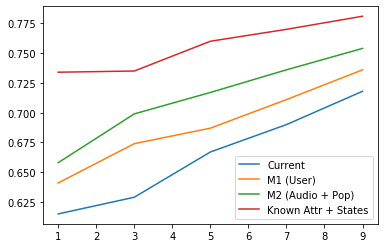

In [136]:
metrics_N.transpose()[[
    'Current',
    'M1 (User)',
    'M2 (Audio + Pop)',
    'Known Attr + States'
]].plot()

### Analysis by session types

In [170]:
metric_cols = ['NDCG@10','AP@10','P@10','RR@10']
test_context_types = test_raw[['session_id','context_type']].groupby('session_id').agg(pd.Series.mode).reset_index()

In [184]:
# Prepare session reason start data
sess_reason_start = test_raw[['session_id','hist_user_behavior_reason_start']].set_index('session_id')
sess_reason_start = pd.get_dummies(sess_reason_start,prefix='',prefix_sep='').reset_index().groupby('session_id').sum()
test_reason_start = sess_reason_start.idxmax(axis=1).reset_index()
test_reason_start.columns = ['session_id','reason_start']
test_reason_start['session_length'] = list(test_raw.groupby('session_id').count()['session_length'])
test_reason_start['reason_start_count'] = list(sess_reason_start.max(axis=1))
test_reason_start['avg_reason_start'] = test_reason_start['reason_start_count'] / test_reason_start['session_length']
test_reason_start

,session_id,reason_start,session_length,reason_start_count,avg_reason_start
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,fwdbtn,10,5,0.500000
1,36_0004794d-dca2-426a-b4d1-0f5fdbd0c1a4,fwdbtn,16,14,0.875000
2,36_0007583d-ca87-4edc-8282-987bd32c95be,trackdone,20,14,0.700000
3,36_00095e9c-b1c4-4040-874f-fedc5838ce62,fwdbtn,20,16,0.800000
4,36_0009b5af-9798-4567-a7e7-03a8c701655f,trackdone,11,9,0.818182
...,...,...,...,...,...
24995,36_ffed5604-4660-46bb-9913-46717d06c3e4,fwdbtn,18,10,0.555556
24996,36_ffee4c66-6f90-4300-a355-bd955611c49c,trackdone,15,8,0.533333
24997,36_fff45a8b-fe42-44d3-80e3-5ca9519386c1,backbtn,14,8,0.571429
24998,36_fffc5e74-fe58-4d7c-9644-5d665761dff1,fwdbtn,11,7,0.636364


In [210]:
# Prepare unique tracks data
test_unique_tracks = test_raw[['session_id','session_position','track_id_clean']]
test_unique_tracks = test_unique_tracks[test_unique_tracks['session_position']>N].drop('session_position',axis=1)
test_unique_tracks = test_unique_tracks.groupby('session_id').nunique().drop('session_id', axis=1).reset_index()
test_unique_tracks.columns = ['session_id','unique_tracks']
test_unique_tracks

,session_id,unique_tracks
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,5
1,36_0004794d-dca2-426a-b4d1-0f5fdbd0c1a4,11
2,36_0007583d-ca87-4edc-8282-987bd32c95be,15
3,36_00095e9c-b1c4-4040-874f-fedc5838ce62,15
4,36_0009b5af-9798-4567-a7e7-03a8c701655f,6
...,...,...
24995,36_ffed5604-4660-46bb-9913-46717d06c3e4,7
24996,36_ffee4c66-6f90-4300-a355-bd955611c49c,9
24997,36_fff45a8b-fe42-44d3-80e3-5ca9519386c1,7
24998,36_fffc5e74-fe58-4d7c-9644-5d665761dff1,6


In [211]:
# Prepare session data
pred_metrics1_comp = copy.deepcopy(pred_metrics1)
pred_metrics1_comp = pred_metrics1_comp.rename(columns={'NDCG@10_top1':'NDCG@10','AP@10_top1':'AP@10','P@10_top1':'P@10','RR@10_top1':'RR@10'})
pred_metrics1_comp['Top Feat'] = list(preds_top1['top1'])
pred_metrics1_comp['Current NDCG@10'] = list(current_metrics['NDCG@10'])
pred_metrics1_comp['Known Top Feat'] = list(true_preds_top1['top1'])
pred_metrics1_comp['Known NDCG@10'] = list(true_pred_metrics1['NDCG@10_top1'])
pred_metrics1_comp['Avg Skips'] = 1 - (pred_metrics1_comp['Relevant remaining'] / pred_metrics1_comp['Length remaining'])
pred_metrics1_comp['delta'] = pred_metrics1_comp['Known NDCG@10'] - pred_metrics1_comp['Current NDCG@10']
pred_metrics1_comp = pred_metrics1_comp.merge(test_context_types,on='session_id')
pred_metrics1_comp = pred_metrics1_comp.merge(test_reason_start,on='session_id')
pred_metrics1_comp = pred_metrics1_comp.merge(test_unique_tracks,on='session_id')
pred_metrics1_comp['Avg Unique Tracks'] = pred_metrics1_comp['unique_tracks'] / pred_metrics1_comp['Length remaining']
pred_metrics1_comp

,session_id,NDCG@10,AP@10,P@10,RR@10,Relevant firstN,Relevant remaining,Length remaining,Top Feat,Current NDCG@10,Known Top Feat,Known NDCG@10,Avg Skips,delta,context_type,reason_start,session_length,reason_start_count,avg_reason_start,unique_tracks,Avg Unique Tracks
0,36_00042572-ee58-48eb-a6fc-675bda0bbb98,0.850345,0.700000,0.400000,1.000000,4,2,5,acousticness,0.850345,beat_strength,0.919721,0.600000,0.069376,catalog,fwdbtn,10,5,0.500000,5,1.000000
1,36_0007583d-ca87-4edc-8282-987bd32c95be,1.000000,1.000000,1.000000,1.000000,1,15,15,mechanism,1.000000,valence,1.000000,0.000000,0.000000,personalized_playlist,trackdone,20,14,0.700000,15,1.000000
2,36_0009b5af-9798-4567-a7e7-03a8c701655f,1.000000,1.000000,1.000000,1.000000,4,6,6,acousticness,1.000000,acousticness,1.000000,0.000000,0.000000,radio,trackdone,11,9,0.818182,6,1.000000
3,36_0009bf71-73ae-41bf-bc2a-84acfbb7cab9,0.540075,0.359524,0.428571,0.250000,2,3,7,speechiness,0.619669,speechiness,0.540075,0.571429,-0.079593,catalog,fwdbtn,12,7,0.583333,4,0.571429
4,36_000c1684-8086-4151-b660-be5100368dc2,0.790386,0.600000,0.200000,1.000000,3,2,15,tempo,0.613147,mode,0.501266,0.866667,-0.111881,radio,fwdbtn,20,16,0.800000,15,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,36_ffcd0f76-e154-45fe-b561-c38f86729852,0.921602,0.946781,0.900000,1.000000,3,14,15,beat_strength,0.779908,valence,0.930569,0.066667,0.150661,catalog,trackdone,20,14,0.700000,12,0.800000
13101,36_ffce11b5-0719-4d49-90e4-741fd046e0da,0.653393,0.525000,0.444444,0.333333,3,4,9,speechiness,0.848583,organism,0.893255,0.555556,0.044671,user_collection,fwdbtn,14,10,0.714286,9,1.000000
13102,36_ffce79ff-f6de-4d22-a369-d2280798f17c,0.434033,0.386905,0.300000,0.500000,4,5,15,bounciness,0.459972,bounciness,0.434033,0.666667,-0.025939,user_collection,fwdbtn,20,10,0.500000,15,1.000000
13103,36_ffd5b861-f43a-47c3-a165-0c6435d7ff9b,0.693426,0.583333,0.333333,0.500000,3,2,6,loudness,0.831555,danceability,0.831555,0.666667,0.000000,editorial_playlist,fwdbtn,11,7,0.636364,6,1.000000


In [230]:
# Analysis by session length
avg_sess_remaining_bins = pd.cut(pred_metrics1_comp["Length remaining"], [5,8,12,15], include_lowest=True)
group_sess_remaining = pred_metrics1_comp.groupby(avg_sess_remaining_bins).mean()
group_sess_remaining['% sessions'] = pred_metrics1_comp.groupby(avg_sess_remaining_bins).size() / len(pred_metrics1_comp) * 100
group_sess_remaining['Delta'] = group_sess_remaining['NDCG@10'] - group_sess_remaining['Current NDCG@10']
group_sess_remaining = group_sess_remaining[['% sessions','Current NDCG@10','NDCG@10','Delta','Known NDCG@10']]
group_sess_remaining.index = ['10-13','14-17','18-20']
group_sess_remaining.index = group_sess_remaining.index.rename('Session Length')
group_sess_remaining.round(3)

,% sessions,Current NDCG@10,NDCG@10,Delta,Known NDCG@10
Session Length,,,,,
10-13,32.438,0.781,0.806,0.025,0.828
14-17,18.726,0.685,0.713,0.028,0.745
18-20,48.836,0.585,0.598,0.014,0.658


In [213]:
# Analysis by avg skips
avg_skips_bins = pd.cut(pred_metrics1_comp["Avg Skips"], np.arange(0, 1+0.25, 0.25), include_lowest=True)
group_skips = pred_metrics1_comp.groupby(avg_skips_bins).mean()
group_skips['% sessions'] = pred_metrics1_comp.groupby(avg_skips_bins).size() / len(pred_metrics1_comp) * 100
group_skips['Delta'] = group_skips['NDCG@10'] - group_skips['Current NDCG@10']
group_skips = group_skips[['% sessions','Current NDCG@10','NDCG@10','Delta','Known NDCG@10']]
group_skips.index = ['[0.0, 0.25]'] + list(group_skips.index)[1:]
group_skips.index = group_skips.index.rename('Avg Skips')
group_skips.round(3)

,% sessions,Current NDCG@10,NDCG@10,Delta,Known NDCG@10
Avg Skips,,,,,
"[0.0, 0.25]",29.576,0.929,0.940,0.011,0.947
"(0.25, 0.5]",23.205,0.704,0.729,0.025,0.757
"(0.5, 0.75]",25.975,0.553,0.579,0.027,0.633
"(0.75, 1.0]",21.244,0.402,0.422,0.020,0.514


In [214]:
# Analysis by context type
group_context = pred_metrics1_comp.groupby('context_type').mean()
group_context['% sessions'] = pred_metrics1_comp.groupby('context_type').size() / len(pred_metrics1_comp) * 100
group_context['Delta'] = group_context['NDCG@10'] - group_context['Current NDCG@10']
group_context = group_context[['% sessions','Current NDCG@10','NDCG@10','Delta','Known NDCG@10']].sort_values('% sessions',ascending=False)
group_context.round(3)

,% sessions,Current NDCG@10,NDCG@10,Delta,Known NDCG@10
context_type,,,,,
user_collection,44.151,0.656,0.676,0.021,0.722
radio,19.931,0.652,0.664,0.012,0.709
catalog,16.505,0.695,0.724,0.029,0.758
editorial_playlist,13.819,0.667,0.689,0.022,0.726
personalized_playlist,4.205,0.752,0.770,0.018,0.799
charts,1.389,0.670,0.666,-0.004,0.728


In [215]:
# Analysis by reason start
group_start = pred_metrics1_comp.groupby('reason_start').mean()
group_start['% sessions'] = pred_metrics1_comp.groupby('reason_start').size() / len(pred_metrics1_comp) * 100
group_start['Delta'] = group_start['NDCG@10'] - group_start['Current NDCG@10']
group_start = group_start[['% sessions','Current NDCG@10','NDCG@10','Delta','Known NDCG@10']].sort_values('% sessions',ascending=False)
group_start.round(3)

,% sessions,Current NDCG@10,NDCG@10,Delta,Known NDCG@10
reason_start,,,,,
fwdbtn,52.591,0.554,0.576,0.022,0.637
trackdone,34.933,0.874,0.886,0.012,0.899
backbtn,9.119,0.520,0.571,0.051,0.612
clickrow,3.335,0.679,0.682,0.003,0.735
appload,0.015,0.724,0.730,0.006,0.831
trackerror,0.008,0.980,0.980,0.000,0.980
